In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import operator
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

C:\Users\lenovo\Anaconda3\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
np.random.seed(0) #generate data for illustrating outlier detection
X = np.linspace(0, 100, 100)
y = 0.5 * X + np.random.normal(0, 5, 100)

# outliers 1
outliers_x = np.array([10, 30, 70])
outliers_y = np.array([150, -50, 200])
X_outliers = np.append(X, outliers_x)
y_outliers = np.append(y, outliers_y)

# Adding more outliers
additional_outliers_x = np.random.rand(10) * 100
additional_outliers_y = 3 * additional_outliers_x + np.random.normal(0, 5, 10) + 300
X_outliers = np.append(X_outliers, additional_outliers_x)
y_outliers = np.append(y_outliers, additional_outliers_y)

# Combine the original data with the outliers
X_combined = np.append(X, X_outliers)
y_combined = np.append(y, y_outliers)

In [3]:
# Calculate and print the mean and STD before cleaning
mean_before = np.mean(y_combined)
std_dev_before = np.std(y_combined)
print("Before Cleaning - Mean:", mean_before, "Std Dev:", std_dev_before)

# Detect and remove outliers using IQR
Q1, Q3 = np.percentile(y_combined, [25, 75])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying points that are not outliers
non_outlier_mask = (y_combined >= lower_bound) & (y_combined <= upper_bound)
X_clean = X_combined[non_outlier_mask]
y_clean = y_combined[non_outlier_mask]

# Calculate and print the mean and STD after cleaning
mean_after = np.mean(y_clean)
std_dev_after = np.std(y_clean)
print("After Cleaning - Mean:", mean_after, "Std Dev:", std_dev_after)


Before Cleaning - Mean: 44.77518014696851 Std Dev: 86.38525453039634
After Cleaning - Mean: 25.299040077672426 Std Dev: 15.009958645010283


In [4]:
 # Fitting linear regression models
model_with_outliers = LinearRegression().fit(X_outliers.reshape(-1, 1), y_outliers)
model_clean = LinearRegression().fit(X_clean.reshape(-1, 1), y_clean)

# Making predictions for plotting
X_range = np.linspace(X_combined.min(), X_combined.max(), len(X_combined)).reshape(-1, 1)
y_pred_with_outliers = model_with_outliers.predict(X_range)
y_pred_clean = model_clean.predict(X_range)


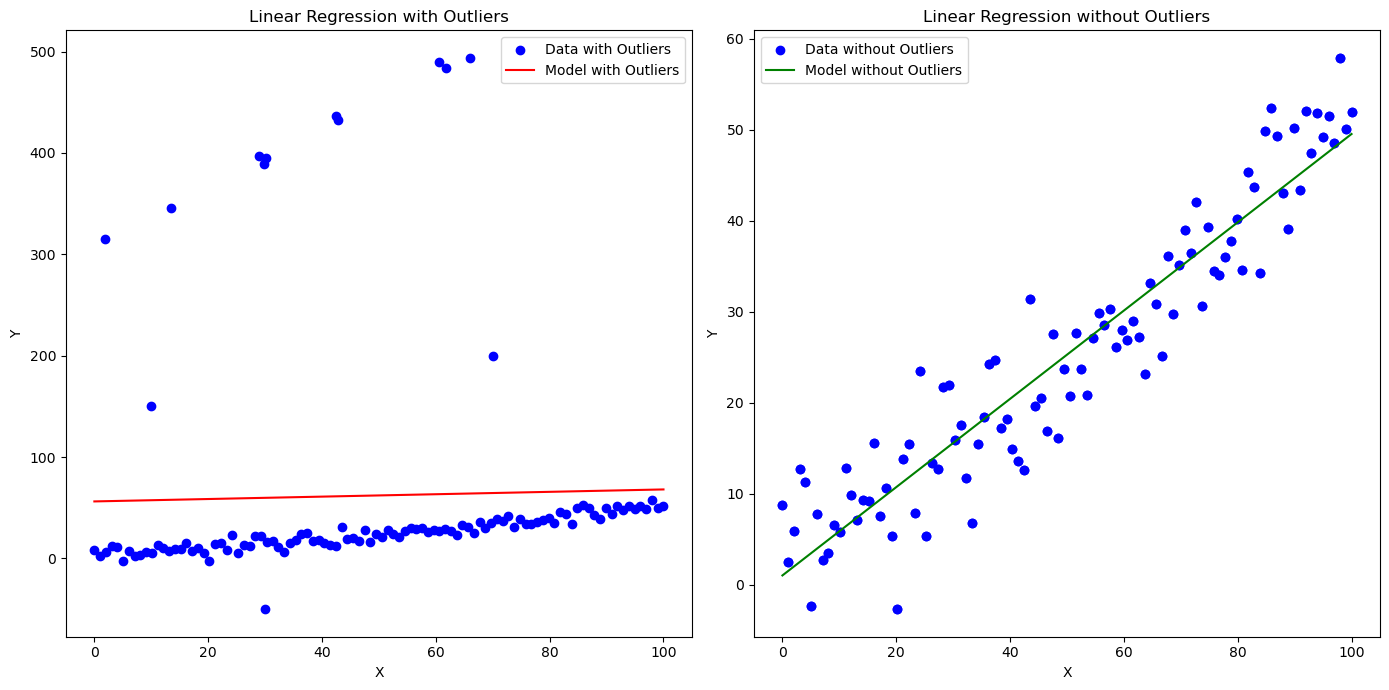

In [5]:
# Plot the data with and without outliers
plt.figure(figsize=(14, 7))

# Plot with all data including outliers
plt.subplot(1, 2, 1)
plt.scatter(X_outliers, y_outliers, color='blue', label='Data with Outliers')
plt.plot(X_range, y_pred_with_outliers, color='red', label='Model with Outliers')
plt.title('Linear Regression with Outliers')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Plot with data after cleaning outliers
plt.subplot(1, 2, 2)
plt.scatter(X_clean, y_clean, color='blue', label='Data without Outliers')
plt.plot(X_range, y_pred_clean, color='green', label='Model without Outliers')
plt.title('Linear Regression without Outliers')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
df = pd.read_csv("NIFTY50_ALL.csv") 
#stock data from Indian bourses to illustrate the challenges regarding overfitting, multicollinearity and lack of interpretation

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235192 entries, 0 to 235191
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Date                235192 non-null  object 
 1   Symbol              235192 non-null  object 
 2   Series              235192 non-null  object 
 3   Prev Close          235192 non-null  float64
 4   Open                235192 non-null  float64
 5   High                235192 non-null  float64
 6   Low                 235192 non-null  float64
 7   Last                235192 non-null  float64
 8   Close               235192 non-null  float64
 9   VWAP                235192 non-null  float64
 10  Volume              235192 non-null  int64  
 11  Turnover            235192 non-null  float64
 12  Trades              120344 non-null  float64
 13  Deliverable Volume  219115 non-null  float64
 14  %Deliverble         219115 non-null  float64
dtypes: float64(11), int64(1), object(3

In [8]:
df = df[["Date", "Symbol", "Close"]]

In [9]:
df["Symbol"].value_counts() #this gives the number of days for which each stock was present on the NIfty50 index

IOC           5306
CIPLA         5306
M&M           5306
ICICIBANK     5306
ONGC          5306
              ... 
MUNDRAPORT    1023
TELCO          999
KOTAKMAH       502
SSLT           388
JSWSTL         123
Name: Symbol, Length: 65, dtype: int64

In [10]:
df=df[(df["Date"]>="2016-01-01") & (df["Date"]<="2021-01-01")].reset_index(drop=True)
#choose stock data from 2016 to 2020

In [11]:
df["Symbol"].unique() #stocks for which data is present from 2016 to 2020

array(['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV',
       'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA',
       'COALINDIA', 'DRREDDY', 'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH',
       'HDFC', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR',
       'ICICIBANK', 'INDUSINDBK', 'INFY', 'IOC', 'ITC', 'JSWSTEEL',
       'KOTAKBANK', 'LT', 'M&M', 'MARUTI', 'NESTLEIND', 'NTPC', 'ONGC',
       'POWERGRID', 'RELIANCE', 'SBIN', 'SHREECEM', 'SUNPHARMA',
       'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO',
       'UPL', 'VEDL', 'WIPRO', 'ZEEL'], dtype=object)

In [12]:
#select few prominent stocks to illustrate correlation and multicollinearity

Adani_Ports = df.loc[df["Symbol"]=="ADANIPORTS", ("Close")].reset_index(drop=True)
Axis_Bank = df.loc[df["Symbol"]=="AXISBANK", ("Close")].reset_index(drop=True)
HDFC_Bank = df.loc[df["Symbol"]=="HDFCBANK", ("Close")].reset_index(drop=True)
HDFC = df.loc[df["Symbol"]=="HDFC", ("Close")].reset_index(drop=True)
Dr_Reddy = df.loc[df["Symbol"]=="DRREDDY", ("Close")].reset_index(drop=True)
Titan = df.loc[df["Symbol"]=="TITAN", ("Close")].reset_index(drop=True)
Wipro = df.loc[df["Symbol"]=="WIPRO", ("Close")].reset_index(drop=True)
Infy = df.loc[df["Symbol"]=="INFY", ("Close")].reset_index(drop=True)
M_M = df.loc[df["Symbol"]=="M&M", ("Close")].reset_index(drop=True)
ITC = df.loc[df["Symbol"]=="ITC", ("Close")].reset_index(drop=True)
JSW_STEEL = df.loc[df["Symbol"]=="JSWSTEEL", ("Close")].reset_index(drop=True)

df["Adani_Ports"] = Adani_Ports
df["Axis_Bank"] = Axis_Bank
df["HDFC_Bank"] = HDFC_Bank
df["HDFC"] = HDFC
df["Dr_Reddy"] = Dr_Reddy
df["Titan"] = Titan
df["Wipro"] = Wipro
df["Infy"] = Infy
df["M_M"] = M_M
df["ITC"] = ITC
df["JSW_Steel"] = JSW_STEEL

In [13]:
df.drop(columns = ["Symbol", "Close"], inplace=True)
df.dropna(inplace=True)

In [14]:
train = df[df["Date"] <="2020-01-01"] #data from 2016 to 2019
test = df[df["Date"] >= "2020-01-01"] #data afer 2020 considered test data
train.drop(columns=["Date"], inplace=True)
test.drop(columns=["Date"], inplace=True)
columns = train.columns
columns

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14488\1794347232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns=["Date"], inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_14488\1794347232.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns=["Date"], inplace=True)


Index(['Adani_Ports', 'Axis_Bank', 'HDFC_Bank', 'HDFC', 'Dr_Reddy', 'Titan',
       'Wipro', 'Infy', 'M_M', 'ITC', 'JSW_Steel'],
      dtype='object')

In [15]:
#stock excess returns in percentage
train = (train - train.iloc[0])/train.iloc[0]*100
test = (test - test.iloc[0])/test.iloc[0]*100
train

,Adani_Ports,Axis_Bank,HDFC_Bank,HDFC,Dr_Reddy,Titan,Wipro,Infy,M_M,ITC,JSW_Steel
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-3.588114,-2.556124,-1.676234,-3.317573,-1.692080,-0.184633,0.224638,-2.384076,-1.805824,-0.732824,1.723466
2,-4.429079,-2.989553,-2.420207,-3.897652,-1.220807,-1.235620,0.080870,-2.822891,-1.276327,-0.809160,5.462512
3,-5.886750,-4.267615,-1.988519,-3.905598,-2.005726,-1.193012,-0.242609,-3.248134,-3.097957,-3.786260,3.037975
4,-8.428331,-9.035341,-2.989667,-6.277564,-3.757318,-2.272404,-1.186090,-4.926487,-5.366104,-5.465649,-0.063291
...,...,...,...,...,...,...,...,...,...,...,...
982,35.918520,63.703045,16.688863,91.831221,-7.817024,238.730294,-55.018420,-34.046596,-58.244754,-27.694656,-73.792600
983,35.937208,68.959769,17.106774,94.219079,-6.787621,238.432041,-55.512625,-33.322778,-58.102501,-27.664122,-73.816943
984,36.778172,67.615026,17.763490,93.750248,-7.069099,239.085357,-55.261030,-33.689211,-57.569052,-27.267176,-73.602726
985,36.796860,67.615026,16.840413,91.708054,-7.529113,237.437864,-55.827118,-33.847546,-57.991860,-27.419847,-73.704966


In [16]:
train

,Adani_Ports,Axis_Bank,HDFC_Bank,HDFC,Dr_Reddy,Titan,Wipro,Infy,M_M,ITC,JSW_Steel
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-3.588114,-2.556124,-1.676234,-3.317573,-1.692080,-0.184633,0.224638,-2.384076,-1.805824,-0.732824,1.723466
2,-4.429079,-2.989553,-2.420207,-3.897652,-1.220807,-1.235620,0.080870,-2.822891,-1.276327,-0.809160,5.462512
3,-5.886750,-4.267615,-1.988519,-3.905598,-2.005726,-1.193012,-0.242609,-3.248134,-3.097957,-3.786260,3.037975
4,-8.428331,-9.035341,-2.989667,-6.277564,-3.757318,-2.272404,-1.186090,-4.926487,-5.366104,-5.465649,-0.063291
...,...,...,...,...,...,...,...,...,...,...,...
982,35.918520,63.703045,16.688863,91.831221,-7.817024,238.730294,-55.018420,-34.046596,-58.244754,-27.694656,-73.792600
983,35.937208,68.959769,17.106774,94.219079,-6.787621,238.432041,-55.512625,-33.322778,-58.102501,-27.664122,-73.816943
984,36.778172,67.615026,17.763490,93.750248,-7.069099,239.085357,-55.261030,-33.689211,-57.569052,-27.267176,-73.602726
985,36.796860,67.615026,16.840413,91.708054,-7.529113,237.437864,-55.827118,-33.847546,-57.991860,-27.419847,-73.704966


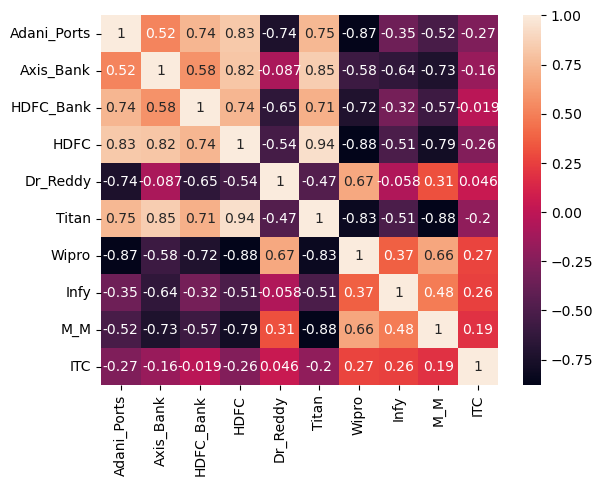

In [17]:
# Correlation plot of all the variables
data = train[
    [
        "Adani_Ports",
        "Axis_Bank",
        "HDFC_Bank",
        "HDFC",
        "Dr_Reddy",
        "Titan",
        "Wipro",
        "Infy",
        "M_M",
        "ITC"
    ]
]
c = data.corr()
sns.heatmap(c, annot=True)
plt.show()

As the heatmap shows, several pairs of stocks display a significant positive correlation, and few even display negative correlation. To pick one example for each case, HDFC and Adani Ports display a strong positive correlation and Titan and M&M display a strong negative correlaltion. This shows that multicollinearity is present in the data.

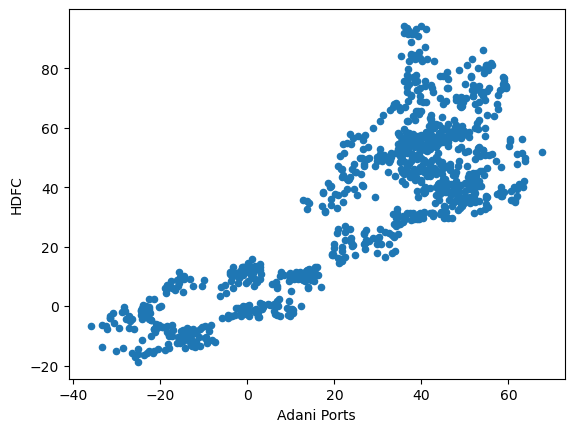

In [18]:
#ScatterPlot of Adani Ports and HDFC - these stocks show the most positive correlation among the selected stocks
# Create scatter plot
scatt = train.plot.scatter(
    x="Adani_Ports",
    y="HDFC",
)
scatt.set(xlabel="Adani Ports", ylabel="HDFC")
plt.show()

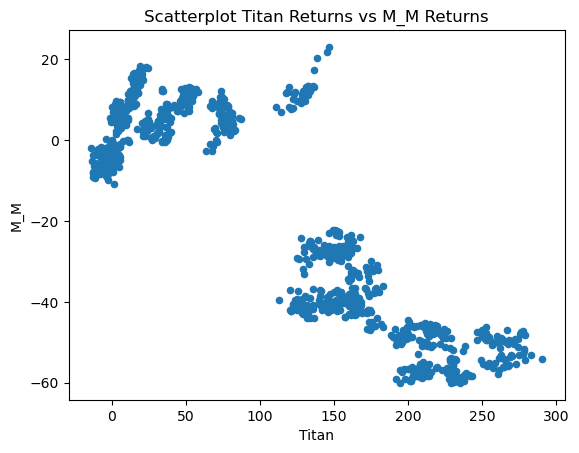

In [19]:
#ScatterPlot of Titan and M&M - these stocks show the most negative correlation among the selected stocks
# Create scatter plot
scatt = train.plot.scatter(
    x="Titan",
    y="M_M",
    title="Scatterplot Titan Returns vs M_M Returns",
)
scatt.set(xlabel="Titan", ylabel="M_M")
plt.show()

In [20]:
#linear Model
# Linear regression result
model = smf.ols("Adani_Ports ~ Axis_Bank + HDFC_Bank + HDFC + Dr_Reddy + Titan + Wipro + Infy + M_M + ITC", data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Adani_Ports   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     713.3
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:52:45   Log-Likelihood:                -3580.4
No. Observations:                 987   AIC:                             7181.
Df Residuals:                     977   BIC:                             7230.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.5234      0.844    -14.832      0.000     -14.180     -10.866
Axis_Bank     -0.2023      0.045     -4.448      0.000      -0.292      -0.113
HDFC_Bank      0.0829      0.014      5.859      0.000       0.055       0.111
HDFC           0.4497      0.043     10.543      0.000       0.366       0.533
Dr_Reddy      -0.4799      0.061     -7.906      0.000      -0.599      -0.361
Titan          0.0854      0.016      5.278      0.000       0.054       0.117
Wipro         -0.2917      0.037     -7.818      0.000      -0.365      -0.218
Infy          -0.1371      0.022     -6.127      0.000      -0.181      -0.093
M_M            0.3474      0.027     12.868      0.000       0.294       0.400
ITC           -0.2411      0.038     -6.384      0.000      -0.315      -0.167
==============================================================================
Omnibus:                       13.384   Durbin-Watson:                   0.106
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.554
Skew:                           0.283   Prob(JB):                      0.00114
Kurtosis:                       3.097   Cond. No.                         497.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
test['Predicted_Adani_Ports'] = model.predict(test)

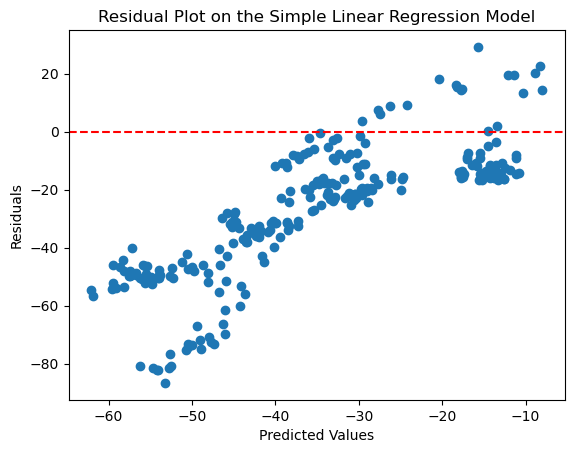

In [22]:
#residual plots
residuals = test["Predicted_Adani_Ports"] - test["Adani_Ports"]

# Create a scatter plot of residuals against predicted values
plt.scatter(test["Predicted_Adani_Ports"], residuals)
plt.title('Residual Plot on the Simple Linear Regression Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

Note the residual plot here on the test data. While we got an R-squared value of 0.868 on the training data set, the residual plot on the test data set shows a skew. Ideally, if our model was working well on the test data, the residual plot should have been an evenly scattered graph, as that would mean that our model's errors were random. The presence of skew means that the model is not fitting the test data well, but we have an excellent R-squared value on the training data. This implies that overfitting is happening.

Let us evaluate our model using few other metrics.

In [23]:
mse = mean_squared_error(test['Adani_Ports'], test['Predicted_Adani_Ports'])

In [24]:
mse

1278.4047302680212

In [25]:
rmse = np.sqrt(mse)
rmse

35.75478611693855

In [26]:
r_squared = r2_score(test['Adani_Ports'], test['Predicted_Adani_Ports'])
r_squared

-5.419313953313906

A negative value of R-squared on the test data here shows that the model performs worse than an average fit line on the training data.

Let use PCA to see if we can remove the problems related to overfitting, multicollinearity and produce a better predictive model.

In [27]:
#Principal Components Analysis
pc = train[
    [
        "Adani_Ports",
        "Axis_Bank",
        "HDFC_Bank",
        "HDFC",
        "Dr_Reddy",
        "Titan",
        "Wipro",
        "Infy",
        "M_M",
        "ITC"
    ]
]
pca = PCA(n_components=6) 
#there are four cells in the correlation matrix earlier where high correlation is observed out of 10 variables. 
#So let us assume we need six PCA components and try to build the model.
pca.fit(pc)

PCA(n_components=6)

In [28]:
# Get proportions of variance and cumulative proportion of variance
pr_var = pca.explained_variance_ratio_
cum_pr = np.cumsum(pca.explained_variance_ratio_)
ind = ["Proportion of variance", "Cumulative proportion of variance"]
cols = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"]
pd.DataFrame(np.vstack((pr_var, cum_pr)), ind, columns=cols)

,PC1,PC2,PC3,PC4,PC5,PC6
Proportion of variance,0.855982,0.067084,0.027451,0.020812,0.011121,0.005718
Cumulative proportion of variance,0.855982,0.923066,0.950518,0.971329,0.982450,0.988167


In [29]:
# Coefficients (Loadings) of 6 Principal Components
pc_res = pd.DataFrame(pca.components_.T, index=list(pc.columns), columns=cols)
pc_res

,PC1,PC2,PC3,PC4,PC5,PC6
Adani_Ports,0.188968,-0.329051,0.464485,-0.403672,0.000755,0.032367
Axis_Bank,0.186391,0.185151,-0.405709,-0.247390,-0.459280,-0.370553
HDFC_Bank,0.291774,-0.788053,-0.497105,0.141802,0.037875,-0.025752
HDFC,0.247477,-0.043951,0.125514,-0.228324,-0.071871,-0.476463
Dr_Reddy,-0.056335,0.232836,-0.266195,-0.097191,-0.110797,-0.228037
Titan,0.836549,0.300530,0.108884,0.185894,-0.159821,0.295659
Wipro,-0.166119,0.159610,-0.329908,0.155102,-0.172994,0.184488
Infy,-0.088412,-0.144639,0.365669,0.703301,-0.409041,-0.389478
M_M,-0.210941,-0.205163,0.135743,-0.321052,-0.720284,0.322624
ITC,-0.016652,-0.038290,-0.114422,0.194527,-0.169093,0.452474


In [30]:
#we can use Titan, HDFC_Bank, M_M, Infy, Axis_Bank, HDFC to model Adani Ports' excess return based on the table of loadings above.
#linear Model
# Linear regression result
model = smf.ols("Adani_Ports ~ HDFC_Bank + Titan + M_M + Infy + HDFC + Axis_Bank", data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Adani_Ports   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     876.7
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:52:45   Log-Likelihood:                -3665.9
No. Observations:                 987   AIC:                             7346.
Df Residuals:                     980   BIC:                             7380.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3214      0.590     -7.324      0.000      -5.479      -3.164
HDFC_Bank      0.1482      0.012     12.321      0.000       0.125       0.172
Titan          0.1733      0.015     11.442      0.000       0.144       0.203
M_M            0.4554      0.027     16.714      0.000       0.402       0.509
Infy          -0.1624      0.024     -6.873      0.000      -0.209      -0.116
HDFC           0.7948      0.037     21.626      0.000       0.723       0.867
Axis_Bank     -0.6239      0.030    -20.985      0.000      -0.682      -0.566
==============================================================================
Omnibus:                       22.426   Durbin-Watson:                   0.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.371
Skew:                           0.372   Prob(JB):                     8.41e-06
Kurtosis:                       3.118   Cond. No.                         309.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
test['Predicted_Adani_Ports'] = model.predict(test)

In [32]:
mse = mean_squared_error(test['Adani_Ports'], test['Predicted_Adani_Ports'])

In [33]:
mse

57.120945942093826

In [34]:
rmse = np.sqrt(mse)
rmse

7.557840031523148

Note how the mean squared error on the test data set is considerably lesser (57.12) compared to 1278 on the vanilla linear regression model, despite the R squared metric on the training data set being higher for the latter. This shows that the vanilla linear regression model was actually overfitting the training dataset and PCA helped us build a better model.

In [35]:
r_squared = r2_score(test['Adani_Ports'], test['Predicted_Adani_Ports'])
r_squared

0.7131759006901537

An R-squared value of 0.71 is far far better than the negative value that we got earlier for the vanilla linear regression model. This shows that using PCA was effective in generating a model with decent predictive power.

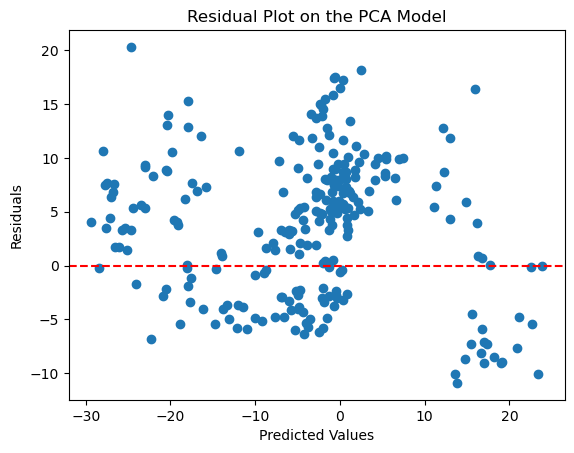

In [36]:
#residual plots
residuals = test["Predicted_Adani_Ports"] - test["Adani_Ports"]

# Create a scatter plot of residuals against predicted values
plt.scatter(test["Predicted_Adani_Ports"], residuals)
plt.title('Residual Plot on the PCA Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

Note how the residuals plot on the test data for the PCA model is reasonably better spread out compared to the skewed plot we saw earlier for the simple linear regression model. We have considerably succeeded in eliminating multicollinearity and overfitting in our PCA model.